Design a shielded planar coil
===============================================


In [1]:
%matplotlib inline
%gui qt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mayavi import mlab
import trimesh

from bfieldtools.mesh_conductor import MeshConductor, StreamFunction, CouplingMatrix
from bfieldtools.contour import scalar_contour
from bfieldtools.viz import plot_3d_current_loops
from bfieldtools.utils import load_example_mesh, combine_meshes

# plane
planemesh = load_example_mesh("10x10_plane", process=False)
rotation_matrix = [[1., 0., 0., 0.], [0., 0., -1., 0.], [0., 1., 0., -1.8], [0., 0., 0., 1.]]
planemesh.apply_transform(rotation_matrix)
print('planemesh info:', planemesh)

# coil
coilmesh = load_example_mesh("coilFG", process=False)
coilmesh.apply_scale(2/3)
print('coilmesh info:', coilmesh)

planemesh info: <trimesh.Trimesh(vertices.shape=(676, 3), faces.shape=(1258, 3))>
coilmesh info: <trimesh.Trimesh(vertices.shape=(12, 3), faces.shape=(12, 3))>


In [3]:
# visualize

to_show = combine_meshes((planemesh, coilmesh))
to_show.show()

C:\Users\nicol\anaconda3\envs\bfield2\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [4]:
# define a grid of points to apply our condition

x_grid = np.linspace(-5, 5, 10)
y_grid = np.linspace(-5, 5, 10)

X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing="ij")
points_grid = np.zeros((X_grid.flatten().shape[0], 3))
points_grid[:, 0] = X_grid.flatten()
points_grid[:, 1] = Y_grid.flatten()
points_grid[:, 2] -= 2.

shield_coil = MeshConductor(mesh_obj=planemesh)
coil = MeshConductor(mesh_obj=coilmesh)

In [5]:
field_shield = shield_coil.B_coupling(points_grid)
field_coil = coil.B_coupling(points_grid)

Computing magnetic field coupling matrix, 676 vertices by 100 target points... took 0.07 seconds.
Computing magnetic field coupling matrix, 12 vertices by 100 target points... took 0.01 seconds.


In [6]:
P = -np.linalg.lstsq(field_shield[:,2,:], field_coil[:,2,:], rcond=False)[0]
P = np.squeeze(P)

# Visualize field lines

In [7]:
# define a grid to plot the field

x_vis = np.linspace(-8, 8, 50)
z_vis = np.linspace(-10, 10, 50)

X_vis, Z_vis = np.meshgrid(x_vis, z_vis, indexing="ij")
points_vis = np.zeros((X_vis.flatten().shape[0], 3))
points_vis[:, 0] = X_vis.flatten()
points_vis[:, 2] = Z_vis.flatten()

In [8]:
field_shield = shield_coil.B_coupling(points_vis)
field_coil = coil.B_coupling(points_vis)

Computing magnetic field coupling matrix, 676 vertices by 2500 target points... took 0.65 seconds.
Computing magnetic field coupling matrix, 12 vertices by 2500 target points... took 0.02 seconds.


In [12]:
current_multiplier = 100000

In [13]:
# multiply the field for the current 
shield_vis = np.dot(field_shield, current_multiplier*P)  # shape = (number_of_points, 3)
total = np.squeeze(field_coil) + np.squeeze(shield_vis)

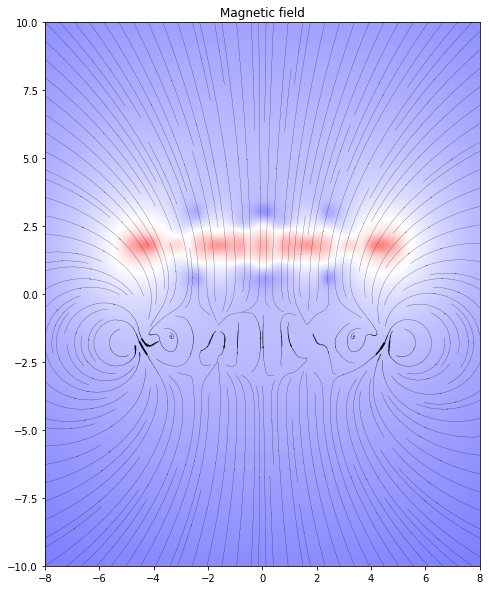

In [14]:
# plot the tot field

to_plot = np.delete(total.T, 1, 0).reshape(2, x_vis.shape[0], z_vis.shape[0])
lw = np.sqrt(to_plot[0] ** 2 + to_plot[1] ** 2)
linewidth = 2 * np.log(lw / np.max(lw) * np.e + 1.1)

plt.figure(figsize=(20, 10))
plt.title("Magnetic field")
plt.imshow(np.log(lw.T), alpha=.5, interpolation='spline16', cmap='bwr', extent=(-8, 8, -10, 10))
plt.streamplot(
    x_vis,
    z_vis,
    to_plot[0].T,
    to_plot[1].T,
    density=2,
    linewidth=linewidth.T,
    color="k",
    integration_direction="both",
    arrowsize=0.1)
plt.show()